# Motivation

&#9708; <span style="color:green"><span style="font-family:Comic Sans MS">**Gradient Ascent Take-Home Assignment-1**</span></span>

&#9708; <span style="color:green"> **Option-I : Business Names**</span>
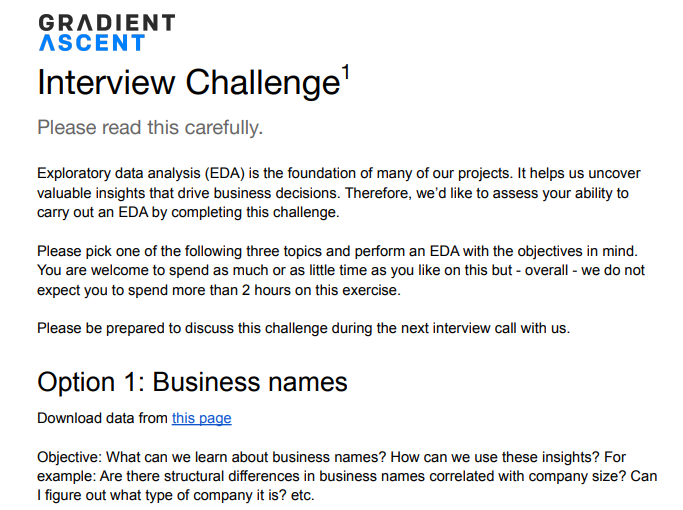

# Train-Of-Thought

- [x]    Feature Engineering
    

- [x]    Feature Selection  


- [x]    Train-Test Split

# Load Libraries

In [2]:
import pandas as pd
import numpy as np
import warnings
import os
import re
import math
import time
import swifter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

In [3]:
import nltk
import spacy
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

In [42]:
import seaborn as sns

# Utilities

In [16]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join(
        [word for word in str(text).split() if word not in STOPWORDS])


def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "J": wordnet.ADJ,
        "R": wordnet.ADV
    }
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([
        lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN))
        for word, pos in pos_tagged_text
    ])


def pre_process(input_df, column='text_dump'):
    input_df[column] = input_df[column].astype(str)
    input_df["pre_processed_" + column] = input_df[column].str.lower()
    input_df["pre_processed_" +
             column] = input_df["pre_processed_" + column].swifter.apply(
                 lambda text: remove_punctuation(text))
    input_df["pre_processed_" +
             column] = input_df["pre_processed_" + column].swifter.apply(
                 lambda text: remove_stopwords(text))
    input_df["pre_processed_" +
             column] = input_df["pre_processed_" + column].swifter.apply(
                 lambda text: lemmatize_words(text))
    return input_df


def entropy(s):
    l = float(len(s))
    return (-sum(map(lambda a: (a / l) * math.log2(a / l),
                     Counter(s).values())))


pos_family = {
    'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
    'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
    'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    'adj': ['JJ', 'JJR', 'JJS'],
    'adv': ['RB', 'RBR', 'RBS', 'WRB']
}


def check_pos_tag(x, flag):
    cnt = 0
    try:
        k = pd.Series([
            list(x)[1] for x in nltk.pos_tag(nltk.word_tokenize(str(x)))
        ]).value_counts()
        for i in pos_family[flag]:
            if i in k.index.tolist():
                cnt = cnt + k[i]
    except:
        pass
    return cnt


def extract_density_based_features(data, column='text_dump'):
    feature_df = pd.DataFrame()

    feature_df['char_count' + '_' + column] = data[column].apply(len)
    feature_df['content_word_count' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: len(str(x).split(" ")))
    feature_df['noun_count' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: check_pos_tag(x, 'noun'))
    feature_df['verb_count' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: check_pos_tag(x, 'verb'))
    feature_df['adj_count' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: check_pos_tag(x, 'adj'))
    feature_df['adv_count' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: check_pos_tag(x, 'adv'))
    feature_df['pron_count' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: check_pos_tag(x, 'pron'))
    feature_df['word_density' + '_' +
               column] = feature_df['char_count' + '_' + column] / (
                   feature_df['content_word_count' + '_' + column] + 1)
    feature_df['avg_word_length'+'_'+column] = feature_df['content_word_count'+'_'+column] / \
        (feature_df['char_count'+'_'+column]+1)
    feature_df['noun_density' + '_' +
               column] = feature_df['noun_count' + '_' + column] / (
                   feature_df['content_word_count' + '_' + column] + 1)
    feature_df['verb_density' + '_' +
               column] = feature_df['verb_count' + '_' + column] / (
                   feature_df['content_word_count' + '_' + column] + 1)
    feature_df['adj_density' + '_' +
               column] = feature_df['adj_count' + '_' + column] / (
                   feature_df['content_word_count' + '_' + column] + 1)
    feature_df['adv_density' + '_' +
               column] = feature_df['adv_count' + '_' + column] / (
                   feature_df['content_word_count' + '_' + column] + 1)
    feature_df['pron_density' + '_' +
               column] = feature_df['pron_count' + '_' + column] / (
                   feature_df['content_word_count' + '_' + column] + 1)
    feature_df['avg_pos_density' + '_' + column] = (feature_df[[
        'noun_density' + '_' + column, 'verb_density' + '_' + column,
        'adj_density' + '_' + column, 'adv_density' + '_' + column,
        'pron_density' + '_' + column
    ]].sum(axis=1) / 5)
    return feature_df


def add_static_column_features(data, column='text_dump'):
    feature_df = pd.DataFrame()

    feature_df['no_of_dots' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('.')).copy()
    feature_df['no_of_hyphen' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('-')).copy()
    feature_df['no_of_underscore' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('_')).copy()
    feature_df['no_of_equal' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('=')).copy()
    feature_df['no_of_forward_slash' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('/')).copy()
    feature_df['no_of_question_marks' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('?')).copy()
    feature_df['no_of_semicolon' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count(';')).copy()
    feature_df['no_of_open_parenthesis' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('(')).copy()
    feature_df['no_of_mod' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('%')).copy()
    feature_df['no_of_ampersand' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('&')).copy()
    feature_df['no_of_@' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('@')).copy()
    feature_df['no_of_double_slash' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: str(x).count('//')).copy()
    feature_df['no_of_digits' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: sum(c.isdigit() for c in x)).copy()
    feature_df['column_entropy' + '_' +
               column] = data[column].swifter.set_npartitions(8).apply(
                   lambda x: entropy(x)).copy()
    return feature_df

# Load Data

In [7]:
data = pd.read_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_processed.feather"
)
data['target'] = data.industry.swifter.apply(lambda x: 1
                                             if str(x) == 'missing' else 0)
data.drop(columns=['industry'],inplace=True)

In [8]:
print(data.shape)
data.head()

(7173426, 10)


,name,domain,year founded,size range,locality,country,linkedin url,current employee estimate,total employee estimate,target
0,ibm,ibm.com,1911,10001+,"new york, new york, united states",united states,ibm,274047,716906,0
1,tata consultancy services,tcs.com,1968,10001+,"bombay, maharashtra, india",india,tata-consultancy-services,190771,341369,0
2,accenture,accenture.com,1989,10001+,"dublin, dublin, ireland",ireland,accenture,190689,455768,0
3,us army,goarmy.com,1800,10001+,"alexandria, virginia, united states",united states,us-army,162163,445958,0
4,ey,ey.com,1989,10001+,"london, greater london, united kingdom",united kingdom,ernstandyoung,158363,428960,0


# Feature Engineering

In [14]:
feature_data = pd.DataFrame()

## String Based Features

In [13]:
data['text_dump'] = data['name'] + ' ' + data['domain'] + ' ' + data[
    'locality'] + ' ' + data['country'] + ' ' + data['linkedin url']

In [17]:
data = pre_process(data,'text_dump')

In [19]:
data.to_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_processedV1.feather"
)

In [20]:
feature_data = extract_density_based_features(data,'text_dump')

In [35]:
print(feature_data.shape)
feature_data.head()

(7173426, 15)


,char_count_text_dump,content_word_count_text_dump,noun_count_text_dump,verb_count_text_dump,adj_count_text_dump,adv_count_text_dump,pron_count_text_dump,word_density_text_dump,avg_word_length_text_dump,noun_density_text_dump,verb_density_text_dump,adj_density_text_dump,adv_density_text_dump,pron_density_text_dump,avg_pos_density_text_dump
0,63,11,5,2,4,0,0,5.250000,0.171875,0.416667,0.166667,0.333333,0.0,0.000000,0.183333
1,92,9,7,1,1,0,0,9.200000,0.096774,0.700000,0.100000,0.100000,0.0,0.000000,0.180000
2,65,7,7,0,0,0,0,8.125000,0.106061,0.875000,0.000000,0.000000,0.0,0.000000,0.175000
3,76,10,4,1,4,0,1,6.909091,0.129870,0.363636,0.090909,0.363636,0.0,0.090909,0.181818
4,77,10,7,0,3,0,0,7.000000,0.128205,0.636364,0.000000,0.272727,0.0,0.000000,0.181818


``` javascript
feature_data.to_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_featureV1.feather"
)
```

In [34]:
feature_data= pd.read_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_featureV1.feather"
)

In [24]:
feature_data_1 = pd.DataFrame()

In [25]:
feature_data_1 = add_static_column_features(data)

In [27]:
print(feature_data_1.shape)
feature_data_1.head()

(7173426, 14)


,no_of_dots_text_dump,no_of_hyphen_text_dump,no_of_underscore_text_dump,no_of_equal_text_dump,no_of_forward_slash_text_dump,no_of_question_marks_text_dump,no_of_semicolon_text_dump,no_of_open_parenthesis_text_dump,no_of_mod_text_dump,no_of_ampersand_text_dump,no_of_@_text_dump,no_of_double_slash_text_dump,no_of_digits_text_dump,column_entropy_text_dump
0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.987466
1,1,2,0,0,0,0,0,0,0,0,0,0,0,4.081877
2,1,0,0,0,0,0,0,0,0,0,0,0,0,3.770113
3,1,1,0,0,0,0,0,0,0,0,0,0,0,4.059546
4,1,0,0,0,0,0,0,0,0,0,0,0,0,3.917363


In [36]:
feature_data = pd.concat([feature_data, add_static_column_features(data)],
                         axis=1,
                         ignore_index=False,
                         copy=True)

In [37]:
print(feature_data.shape)
feature_data.head()

(7173426, 29)


,char_count_text_dump,content_word_count_text_dump,noun_count_text_dump,verb_count_text_dump,adj_count_text_dump,adv_count_text_dump,pron_count_text_dump,word_density_text_dump,avg_word_length_text_dump,noun_density_text_dump,verb_density_text_dump,adj_density_text_dump,adv_density_text_dump,pron_density_text_dump,avg_pos_density_text_dump,no_of_dots_text_dump,no_of_hyphen_text_dump,no_of_underscore_text_dump,no_of_equal_text_dump,no_of_forward_slash_text_dump,no_of_question_marks_text_dump,no_of_semicolon_text_dump,no_of_open_parenthesis_text_dump,no_of_mod_text_dump,no_of_ampersand_text_dump,no_of_@_text_dump,no_of_double_slash_text_dump,no_of_digits_text_dump,column_entropy_text_dump
0,63,11,5,2,4,0,0,5.250000,0.171875,0.416667,0.166667,0.333333,0.0,0.000000,0.183333,1,0,0,0,0,0,0,0,0,0,0,0,0,3.987466
1,92,9,7,1,1,0,0,9.200000,0.096774,0.700000,0.100000,0.100000,0.0,0.000000,0.180000,1,2,0,0,0,0,0,0,0,0,0,0,0,4.081877
2,65,7,7,0,0,0,0,8.125000,0.106061,0.875000,0.000000,0.000000,0.0,0.000000,0.175000,1,0,0,0,0,0,0,0,0,0,0,0,0,3.770113
3,76,10,4,1,4,0,1,6.909091,0.129870,0.363636,0.090909,0.363636,0.0,0.090909,0.181818,1,1,0,0,0,0,0,0,0,0,0,0,0,4.059546
4,77,10,7,0,3,0,0,7.000000,0.128205,0.636364,0.000000,0.272727,0.0,0.000000,0.181818,1,0,0,0,0,0,0,0,0,0,0,0,0,3.917363


## Numeric

In [38]:
feature_data['delta_emp'] = pd.Series(data['total employee estimate'] -
                              data['current employee estimate'])
feature_data['year_founded'] = data['year founded']

## One-Hot

In [39]:
feature_data = feature_data.join(pd.get_dummies(data['size range']))

In [40]:
print(feature_data.shape)
feature_data.head()

(7173426, 39)


,char_count_text_dump,content_word_count_text_dump,noun_count_text_dump,verb_count_text_dump,adj_count_text_dump,adv_count_text_dump,pron_count_text_dump,word_density_text_dump,avg_word_length_text_dump,noun_density_text_dump,verb_density_text_dump,adj_density_text_dump,adv_density_text_dump,pron_density_text_dump,avg_pos_density_text_dump,no_of_dots_text_dump,no_of_hyphen_text_dump,no_of_underscore_text_dump,no_of_equal_text_dump,no_of_forward_slash_text_dump,no_of_question_marks_text_dump,no_of_semicolon_text_dump,no_of_open_parenthesis_text_dump,no_of_mod_text_dump,no_of_ampersand_text_dump,no_of_@_text_dump,no_of_double_slash_text_dump,no_of_digits_text_dump,column_entropy_text_dump,delta_emp,year_founded,1 - 10,10001+,1001 - 5000,11 - 50,201 - 500,5001 - 10000,501 - 1000,51 - 200
0,63,11,5,2,4,0,0,5.250000,0.171875,0.416667,0.166667,0.333333,0.0,0.000000,0.183333,1,0,0,0,0,0,0,0,0,0,0,0,0,3.987466,442859,1911,0,1,0,0,0,0,0,0
1,92,9,7,1,1,0,0,9.200000,0.096774,0.700000,0.100000,0.100000,0.0,0.000000,0.180000,1,2,0,0,0,0,0,0,0,0,0,0,0,4.081877,150598,1968,0,1,0,0,0,0,0,0
2,65,7,7,0,0,0,0,8.125000,0.106061,0.875000,0.000000,0.000000,0.0,0.000000,0.175000,1,0,0,0,0,0,0,0,0,0,0,0,0,3.770113,265079,1989,0,1,0,0,0,0,0,0
3,76,10,4,1,4,0,1,6.909091,0.129870,0.363636,0.090909,0.363636,0.0,0.090909,0.181818,1,1,0,0,0,0,0,0,0,0,0,0,0,4.059546,283795,1800,0,1,0,0,0,0,0,0
4,77,10,7,0,3,0,0,7.000000,0.128205,0.636364,0.000000,0.272727,0.0,0.000000,0.181818,1,0,0,0,0,0,0,0,0,0,0,0,0,3.917363,270597,1989,0,1,0,0,0,0,0,0


# Feature Selection 

In [55]:
feature_data['target'] = data.target.copy(deep=True)

## Correlation Drop

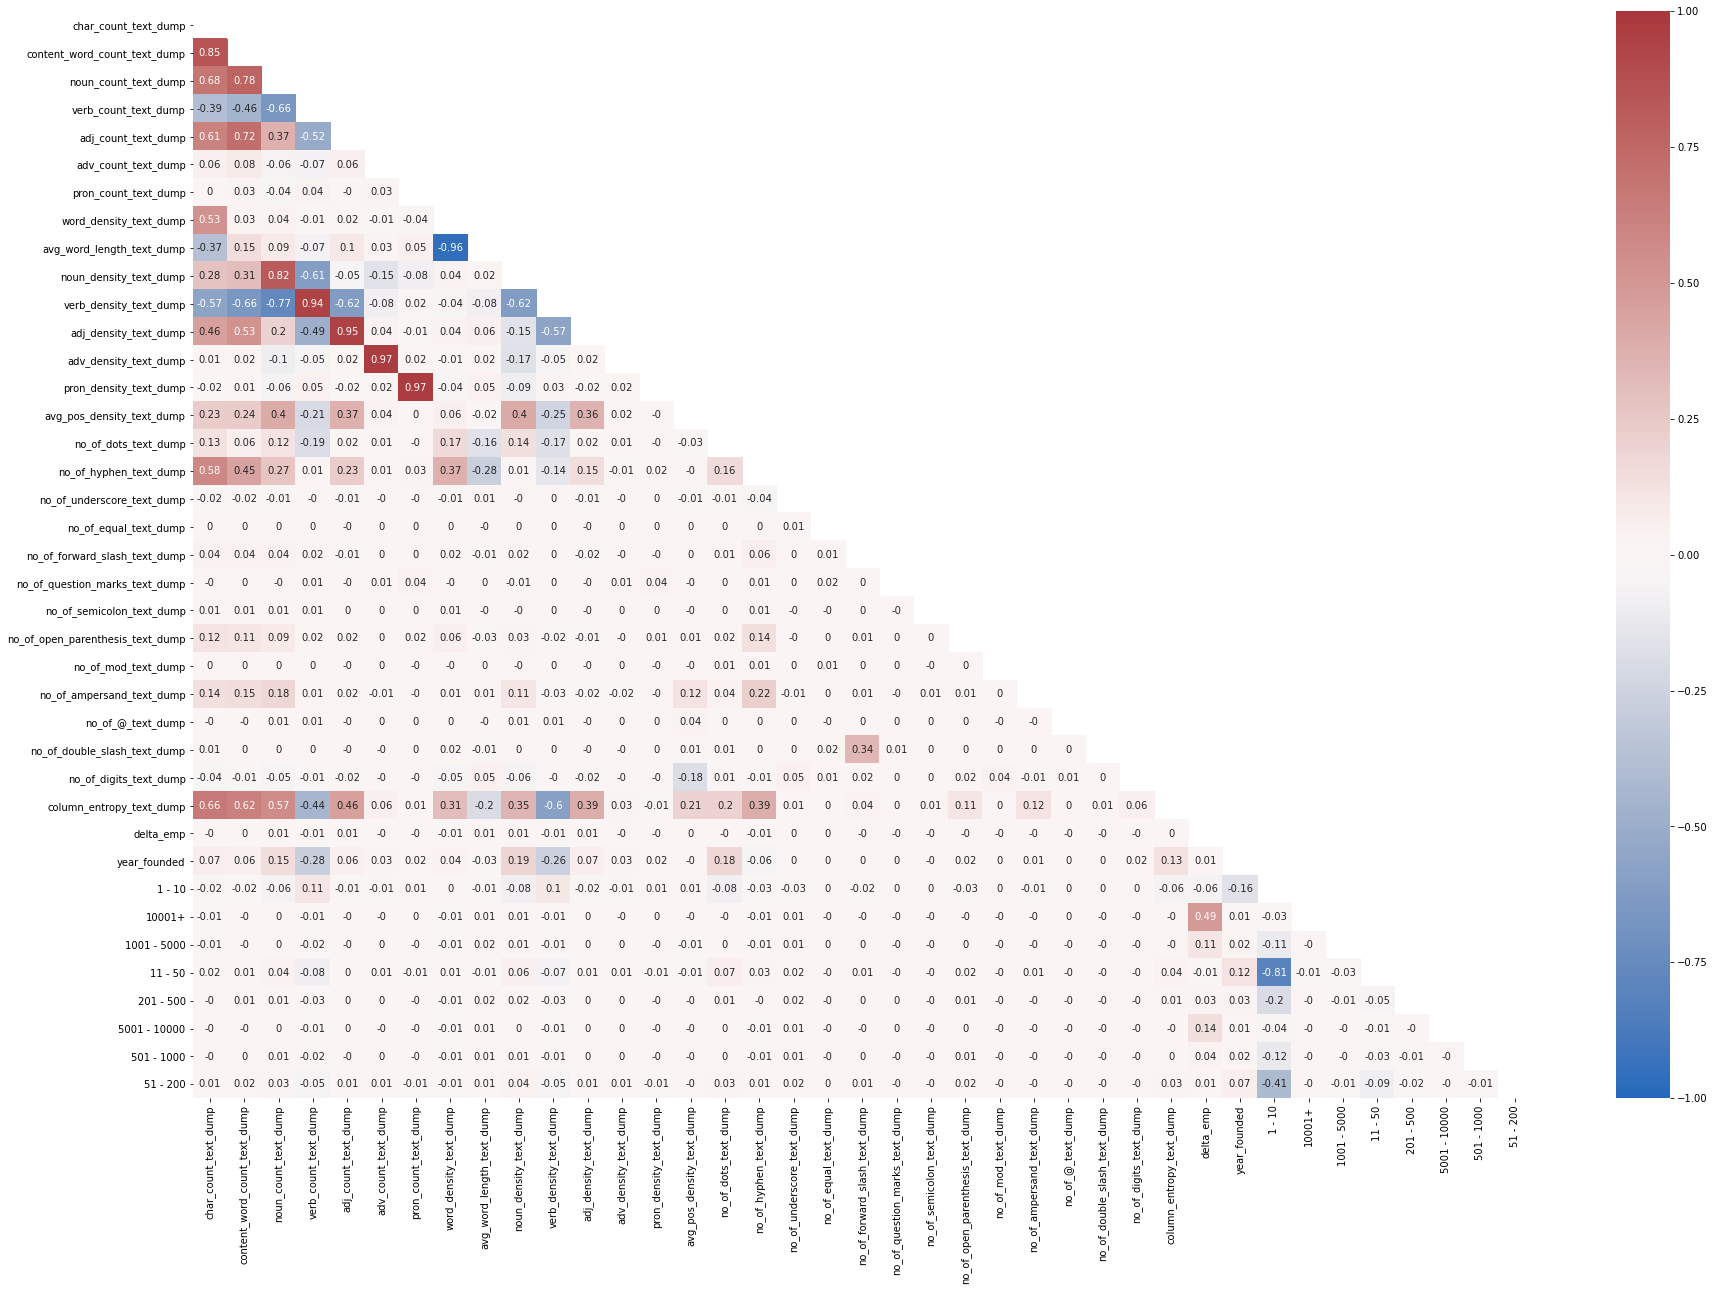

In [45]:
plt.subplots(figsize=(30, 20))
matrix = feature_data.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [47]:
upper_tri = matrix.where(
    np.triu(np.ones(matrix.shape), k=1).astype(np.bool))
to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.90)
]
del upper_tri,mask

In [48]:
len(to_drop)

4

In [49]:
to_drop

['verb_density_text_dump',
 'adj_density_text_dump',
 'adv_density_text_dump',
 'pron_density_text_dump']

In [50]:
feature_data.drop(columns=to_drop,inplace=True)

## Null Drop

In [56]:
feature_data.isnull().sum()

char_count_text_dump                0
content_word_count_text_dump        0
noun_count_text_dump                0
verb_count_text_dump                0
adj_count_text_dump                 0
adv_count_text_dump                 0
pron_count_text_dump                0
word_density_text_dump              0
avg_word_length_text_dump           0
noun_density_text_dump              0
avg_pos_density_text_dump           0
no_of_dots_text_dump                0
no_of_hyphen_text_dump              0
no_of_underscore_text_dump          0
no_of_equal_text_dump               0
no_of_forward_slash_text_dump       0
no_of_question_marks_text_dump      0
no_of_semicolon_text_dump           0
no_of_open_parenthesis_text_dump    0
no_of_mod_text_dump                 0
no_of_ampersand_text_dump           0
no_of_@_text_dump                   0
no_of_double_slash_text_dump        0
no_of_digits_text_dump              0
column_entropy_text_dump            0
delta_emp                           0
year_founded

## Duplicate Drop

In [57]:
feature_data[feature_data.duplicated()].shape

(152890, 36)

In [58]:
feature_data[feature_data.duplicated()]['target'].value_counts()

0    132752
1     20138
Name: target, dtype: int64

## Zero-Variance Drop

In [52]:
[
    col for col in feature_data.columns
    if len(feature_data[col].unique()) < 2
]

[]

## Infinity Drop

In [54]:
feature_data.columns.to_series()[np.isinf(feature_data).any()]

Series([], dtype: object)

# Train-Test Split

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(
    feature_data[feature_data.columns.tolist()[:-1]],
    feature_data.target,
    stratify=feature_data.target,
    shuffle=True,
    random_state=9,
    test_size=0.1)

In [65]:
X_train['target'] = Y_train
print(X_train.shape)
X_train.head()

(6456083, 36)


,char_count_text_dump,content_word_count_text_dump,noun_count_text_dump,verb_count_text_dump,adj_count_text_dump,adv_count_text_dump,pron_count_text_dump,word_density_text_dump,avg_word_length_text_dump,noun_density_text_dump,avg_pos_density_text_dump,no_of_dots_text_dump,no_of_hyphen_text_dump,no_of_underscore_text_dump,no_of_equal_text_dump,no_of_forward_slash_text_dump,no_of_question_marks_text_dump,no_of_semicolon_text_dump,no_of_open_parenthesis_text_dump,no_of_mod_text_dump,no_of_ampersand_text_dump,no_of_@_text_dump,no_of_double_slash_text_dump,no_of_digits_text_dump,column_entropy_text_dump,delta_emp,year_founded,1 - 10,10001+,1001 - 5000,11 - 50,201 - 500,5001 - 10000,501 - 1000,51 - 200,target
2689123,68,8,6,0,2,0,0,7.555556,0.115942,0.666667,0.177778,4,4,0,0,0,0,0,0,0,0,0,0,0,3.912985,0,1996,1,0,0,0,0,0,0,0,0
2074553,68,7,4,2,1,0,0,8.500000,0.101449,0.500000,0.175000,4,6,0,0,0,0,0,0,0,0,0,0,0,3.547813,3,1925,1,0,0,0,0,0,0,0,0
5360121,67,7,2,3,2,0,0,8.375000,0.102941,0.250000,0.175000,1,2,0,0,0,0,0,0,0,0,0,0,0,3.719617,0,2005,1,0,0,0,0,0,0,0,0
6840139,89,8,5,2,1,0,0,9.888889,0.088889,0.555556,0.177778,1,4,0,0,0,0,0,0,0,0,0,0,0,4.138616,1,-999,1,0,0,0,0,0,0,0,0
1401057,109,14,8,1,3,0,0,7.266667,0.127273,0.533333,0.160000,0,0,0,0,0,0,0,0,0,1,0,0,0,4.020939,1,2007,0,0,0,1,0,0,0,0,0


In [66]:
X_test['target'] = Y_test
print(X_test.shape)
X_test.head()

(717343, 36)


,char_count_text_dump,content_word_count_text_dump,noun_count_text_dump,verb_count_text_dump,adj_count_text_dump,adv_count_text_dump,pron_count_text_dump,word_density_text_dump,avg_word_length_text_dump,noun_density_text_dump,avg_pos_density_text_dump,no_of_dots_text_dump,no_of_hyphen_text_dump,no_of_underscore_text_dump,no_of_equal_text_dump,no_of_forward_slash_text_dump,no_of_question_marks_text_dump,no_of_semicolon_text_dump,no_of_open_parenthesis_text_dump,no_of_mod_text_dump,no_of_ampersand_text_dump,no_of_@_text_dump,no_of_double_slash_text_dump,no_of_digits_text_dump,column_entropy_text_dump,delta_emp,year_founded,1 - 10,10001+,1001 - 5000,11 - 50,201 - 500,5001 - 10000,501 - 1000,51 - 200,target
811782,56,6,4,2,0,0,0,8.000000,0.105263,0.571429,0.171429,3,1,0,0,0,0,0,0,0,0,0,0,0,3.907416,3,-999,0,0,0,1,0,0,0,0,0
282013,86,10,7,0,3,0,0,7.818182,0.114943,0.636364,0.181818,1,1,0,0,0,0,0,0,0,0,0,0,0,3.839616,33,1966,0,0,0,0,0,0,0,1,0
7133794,118,11,6,0,5,0,0,9.833333,0.092437,0.500000,0.183333,1,2,0,0,0,0,0,0,0,0,0,0,0,4.135685,1,-999,1,0,0,0,0,0,0,0,1
3068443,104,10,5,2,3,0,0,9.454545,0.095238,0.454545,0.181818,1,1,0,0,0,0,0,0,0,0,0,0,0,4.313804,0,-999,1,0,0,0,0,0,0,0,0
2121511,60,5,3,2,0,0,0,10.000000,0.081967,0.500000,0.166667,1,0,0,0,0,0,0,0,0,0,0,0,0,3.839305,0,2008,1,0,0,0,0,0,0,0,0


In [68]:
X_train.reset_index().to_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_trainV1.feather"
)
X_test.reset_index().to_feather(
    "C:\\Users\\Zeus\\Downloads\\Road_To_Glory\\2022\\Gradient Ascent\\archive\\business_name_testV1.feather"
)